In [1]:
%load_ext autoreload
%autoreload 2 

# Introduction

**What you will learn today**: This lab serves as an introduction to PyTorch. We will learn the different steps required in training a deep learning model with modern libraries, such as PyTorch. The idea is to make the model consistent with the structure of previous labs. In other words, we will simply call the **fit** function (like Scikit-learn!) and the model will train. 

So, which are these steps?

* Preliminaries:
    * load the train and test datasets, `train_dataset` and `test_dataset` (MNIST in our case)
    * turn the datasets into a "dataloaders": `train_dataloader` and `test_dataloader`
    * define your `model` architecture
    * define your `optimizer`, e.g. SGD


* Training: Now we have all the building blocks and we need to make our model "learn". In most cases, the training follows a specific "recipe". Specifically, we feed the `model` the whole `train_dataset` using batches that come from the `train_dataloader`. We repeat this a certain number of times, called `epochs`. Each epoch consists of `batches`. So what do we do for each batch?
    * zero out the optimizer. In essence we prepare the optimizer for the incoming data
    * compute the output of the model $f(\cdot)$ for our current data: $x\mapsto f(x)$
    * compute the loss: $\mathcal{L}(f(x), y)$ where $y$ denotes the ground truth
    * perform the `backpropagation` algorithm which involves computing the gradients and performing the update rule



# Getting the preliminaries out of the way

In [2]:
# first we load all the necessary libraries
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

We now load the datasets. We are going to work with MNIST and our goal is classify digits. This is a popular dataset and PyTorch offers it out-of-the-box, making our life easy! We simply need to call the corresponding method.

In [3]:
# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = transforms.Compose([
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize((0.1307,), (0.3081,))
])

# load the train dataset
train_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# load the test dataset
test_dataset = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)


0it [00:00, ?it/s]

 86%|████████▌ | 8544256/9912422 [01:18<00:00, 9430030.37it/s] 

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


32768it [00:00, 430949.84it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


1654784it [00:00, 8191423.85it/s]                            
8192it [00:00, 175447.11it/s]
/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /Users/distiller/project/conda/conda-bld/pytorch_1603740477510/work/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw
Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [4]:
# define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 2048
LEARNING_RATE = 0.01

# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


However, we cannot use the whole dataset; it is too large for computers to handle. Instead, we perform *stochastic* gradient descent, i.e. we feed the model part of the data called batches. In order to do so, we use Pytorch DataLoaders. 

In [5]:
# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)


# Construct the dataloader for the testing dataset.
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)


Now, let's visualize some samples.

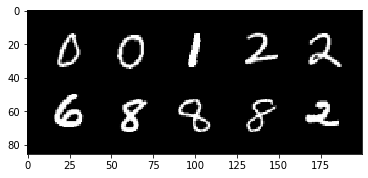

In [6]:
import matplotlib.pyplot as plt
import numpy as np

images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

Now, we are ready to define our model. We will start with a simple model, a MultiLayer Perceptron (MLP) with 2 layers.

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        # define the different modules of the network
        super(Net, self).__init__()
        # input layer has 28x28=784 features 
        self.fc1 = nn.Linear(784, 50)
        # the output layer has 10 neurons. i.e. the number of output classes.
        self.fc2 = nn.Linear(50, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()



    def forward(self, x):
        # transform the image to a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # pass the vectored image through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [8]:
# initialize the model
model = Net()

# move model to device
model = model.to(DEVICE)

# define the optimizer
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE)

We now define:
* the `fit` function that performs the training part
* the `predict` function that takes as input the test dataloader and prints the performance metrics (e.g. accuracy)

In [9]:
def predict(model, test_dataloader, device):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100. * correct / len(test_dataloader.dataset)

    print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)')


We perform a "sanity check". Our model is at the moment initialized randomly and we have 10 classes (each class has approximately the same number of samples). This means that we should get random performance -> ~10% accuracy.

In [10]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0012, Accuracy: 1433/10000 (14%)


In [11]:
def train_epoch(model, train_dataloader, optimizer, device=None):

    running_loss = 0.0

    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)


def fit(model, train_dataloader, optimizer, epochs, device):
    losses = []
    for epoch in range(epochs):
        running_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            # device=device
        )
        print(f"Epoch {epoch}: Loss={running_loss}")
        losses.append(running_loss)

    return losses

In [12]:
losses = fit(
    model=model, 
    train_dataloader=train_dataloader,
    optimizer=optimizer,
    epochs=10,
    device=DEVICE)

Epoch 0: Loss=0.002217098383108775
Epoch 1: Loss=0.002104522975285848


9920512it [01:30, 9430030.37it/s]                             

Epoch 2: Loss=0.0019652518292268117
Epoch 3: Loss=0.001796206267674764
Epoch 4: Loss=0.0016118452310562134
Epoch 5: Loss=0.0014303813099861146
Epoch 6: Loss=0.001265889722108841
Epoch 7: Loss=0.0011257228116194407
Epoch 8: Loss=0.0010112566083669663
Epoch 9: Loss=0.0009193203051884969


Let's visualize the loss progression.

Text(0.5, 1.0, 'Loss progression across epochs')

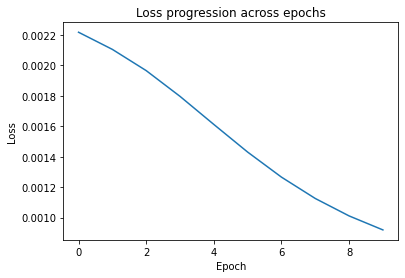

In [13]:
plt.plot(losses)

plt.xlabel('Epoch')
plt.ylabel("Loss")
plt.title("Loss progression across epochs")

In [14]:
predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0004, Accuracy: 8216/10000 (82%)


The results are not very good. There are some major problems. We see from the plot above that the loss keeps dropping and does not "plateau". This indicates that we can run the optimization a few more epochs and improve the performance. Another point is that our learning rate is too sloww or the selection of vanilla SGD as our optimizer is not optimal. In the next section we will see that simply changing the optimizer (from SGD to Adam) yields very different results!

# Putting everything together

So far we have created a model, its optimizer, functions for training and predicting. Our end goal is to have something more "object oriented". In other words, we want a model with the ease and clarity of scikit-learn: simply call model.fit() and training runs.

We throw everything we have written above into a single class (+some extra functionality). After all, every model has a different forward function while the remaining structure stays the same.

In [15]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

class BasicModel(nn.Module):
    def __init__(self):
        super().__init__()
        # Here we define the model modules
        

    def forward(self, x):
        # defines the forward function of the model. 
        raise NotImplementedError


    def fit(self, train_dataloader, optimizer, epochs, device, plot_loss=True):
        losses = []
        for epoch in range(epochs):
            running_loss = self.train_epoch(
                train_dataloader=train_dataloader, 
                optimizer=optimizer, 
                epoch_idx=epoch,
                device=device)
            
            losses.append(running_loss)

        if plot_loss:
            self.plot_loss_progression(losses=losses)

    def plot_loss_progression(self, losses):
        plt.plot(losses)
        plt.xlabel('Epoch')
        plt.ylabel("Loss")
        plt.title("Loss progression across epochs")

    def train_epoch(self, train_dataloader, optimizer, epoch_idx, device):
        running_loss = 0.0

        self.train()
        tk0 = tqdm(train_dataloader, total=len(train_dataloader), desc=f"Epoch {epoch_idx}")
        for batch_idx, (data, target) in enumerate(tk0):
            data, target = data.to(device), target.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            output = self(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            avg_loss = running_loss / (batch_idx + 1)
            tk0.set_postfix(loss=avg_loss, stage="train")

        
        return running_loss / len(train_dataloader.dataset)


    def predict(self, test_dataloader, device):
        self.eval()
        test_loss = 0
        correct = 0
        with torch.no_grad():
            for data, target in test_dataloader:
                data, target = data.to(device), target.to(device)

                output = self(data)
                loss = F.cross_entropy(output, target)
                test_loss += loss.item()
                pred = output.data.max(1, keepdim=True)[1]
                correct += pred.eq(target.data.view_as(pred)).sum()

        test_loss /= len(test_dataloader.dataset)
        accuracy = 100. * correct / len(test_dataloader.dataset)

        print(f'Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(train_dataloader.dataset)} ({accuracy:.0f}%)')

Notice that the class above is not actually a model, but it defines all the relevant functions. Now we create the model by simply **inheriting** the class above and defining two `__init__` and the `forward` functions.

In [16]:
# We create a model identical with the previous one.

class MLP(BasicModel): # inherit the BasicModel class

    def __init__(self):
        super().__init__()
        # input layer has 28x28=784 features 
        self.fc1 = nn.Linear(784, 50)
        # the output layer has 10 neurons. i.e. the number of output classes.
        self.fc2 = nn.Linear(50, 10)
        # we also define the non-linearity 
        self.relu = nn.ReLU()


    def forward(self, x):
        # transform the image to a vector
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)

        # pass the vectored image through the layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

        

Epoch 9: 100%|██████████| 59/59 [00:03<00:00, 19.05it/s, loss=0.0609, stage=train]


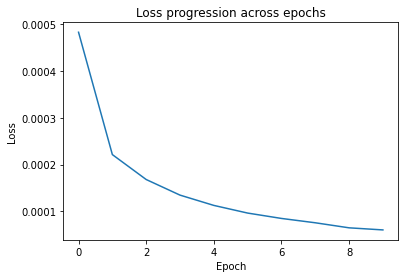

In [17]:
# initialize model and define the optimizer. 
mlp = MLP().to(DEVICE)

# Instead of SGD we will use a more sophisticated one called Adam.
optimizer = optim.Adam(mlp.parameters(), lr=LEARNING_RATE)

# train the mlp
mlp.fit(
    train_dataloader=train_dataloader, 
    optimizer=optimizer,
    epochs=10,
    device=DEVICE)

In [18]:
mlp.predict(test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0001, Accuracy: 9708/60000 (97%)


The results are much better using Adam (in the same number of epochs). This shows the importance of selecting the correct optimizer.

## CNN

Notice that the MLP does not take into account the nature of images: close pixels convey local information that is important. Using an MLP, we do not have the notion of the "pixel neighbourhood". We, therefore, neglect important information with an MLP. There are however models better suited for vision problems, such as Convolutional Neural Networks or CNNs.

With the code structure we have created, we can simply define a CNN and test its performance quickly.

In [19]:
class CNN(BasicModel): 
    def __init__(self):
        super().__init__()

        # We use a Sequential, i.e. the inputs passes through each of
        # the modules below, one-by-one
        self.conv = nn.Sequential(         
            nn.Conv2d(
                in_channels=1,              
                out_channels=16,            
                kernel_size=5,              
                stride=1,                   
                padding=2,                  
            ),                              
            nn.ReLU(),                      
            nn.MaxPool2d(kernel_size=2), 
            nn.Conv2d(
                in_channels=16, 
                out_channels=32, 
                kernel_size=5, 
                stride=1, 
                padding=2),     
            nn.ReLU(),                      
            nn.MaxPool2d(2),    
        )
              
        # fully connected layer, output 10 classes
        self.out = nn.Linear(32 * 7 * 7, 10)    
        
    def forward(self, x):
        x = self.conv(x)
        x = x.view(x.size(0), -1)       
        x = self.out(x)
        return x   # return x for visualization
        

Epoch 9: 100%|██████████| 59/59 [00:25<00:00,  2.33it/s, loss=0.0166, stage=train]


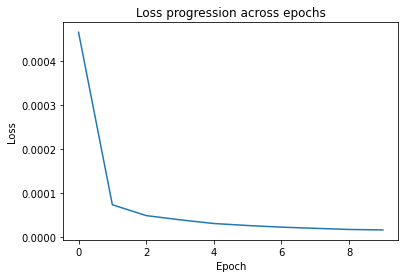

In [20]:
# initialize model and define the optimizer. Instead of SGD we will use a more sophisticated one called Adam.
cnn = CNN().to(DEVICE)

optimizer = optim.Adam(cnn.parameters(), lr=LEARNING_RATE)

# train the mlp
cnn.fit(
    train_dataloader=train_dataloader, 
    optimizer=optimizer,
    epochs=10,
    device=DEVICE)

In [21]:
cnn.predict(test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0000, Accuracy: 9899/60000 (99%)


The CNN outperforms the MLP, which is to be expected in out case.

# Exercise: play with CIFAR10

MNIST is a fairly simple dataset. What happens in more challenging datasets?